In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm

/home/chokellaaaaaaa/epita/s9/stochastique/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
class Config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    img_size = 16
    batch_size = 128
    T = 500             # Nombre d'étapes de diffusion (Time steps)
    lr = 1e-3           # Learning rate
    epochs = 100       

def get_data():
    transform = transforms.Compose([
        transforms.Resize((Config.img_size, Config.img_size)), # Force 16x16
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # Important: met les pixels entre [-1, 1]
    ])
    
    # Charger train (60k) + test (10k) = 70k images au total
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Combiner les deux datasets
    full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
    
    print(f"Dataset complet: {len(full_dataset)} images")
    
    # On drop les labels car on fait du non-supervisé
    return DataLoader(full_dataset, batch_size=Config.batch_size, shuffle=True, drop_last=True)

In [19]:
class DiffusionSchedule:
    def __init__(self, T, device):
        self.T = T
        self.device = device
        
        # Schedule linéaire de alpha (sigma_i dans le cours)
        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        
        # alpha_bar (produit cumulatif des alpha)
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def noise_images(self, x0, t):
        """
        Formule de bruitage : xt = sqrt(sigma_bar) * x0 + sqrt(1 - sigma_bar) * xi
        """
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        
        # xi ~ N(0, I)
        xi = torch.randn_like(x0)
        xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * xi

        return xt, xi

In [21]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(1, dim) # Projection simple du temps

    def forward(self, t):
        # t est normalisé entre 0 et 1 pour la stabilité
        t = t.view(-1, 1).float() 
        return F.silu(self.linear(t))

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encodage du temps
        self.time_mlp = TimeEmbedding(32)

        # Encoder (Descente)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 16x16 -> 8x8
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # 8x8 -> 4x4

        # Bottleneck
        self.bottleneck = nn.Conv2d(128, 128, 3, padding=1)

        # Decoder (Remontée)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2) # 4x4 -> 8x8
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # 8x8 -> 16x16
        self.out = nn.Conv2d(32, 1, 3, padding=1) # Sortie 1 canal (gris)

    def forward(self, x, t):
        # Injection du temps (t)
        t_emb = self.time_mlp(t / Config.T) # Normalisation du temps
        t_emb = t_emb[:, :, None, None]     # Broadcast pour additionner aux images

        # Passages
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1 + t_emb)) # On ajoute l'info temporelle
        x3 = F.relu(self.conv3(x2))

        b = F.relu(self.bottleneck(x3))

        # Connexions résiduelles (Skip connections) simplifiées
        x_up1 = F.relu(self.up1(b))
        x_up2 = F.relu(self.up2(x_up1 + x2)) # Ajout du skip connection
        
        return self.out(x_up2) # Prédiction du bruit

In [ ]:
def train(dataloader):
    print("Initialisation...")
    model = SimpleUNet().to(Config.device)
    optimizer = optim.Adam(model.parameters(), lr=Config.lr)
    diffusion = DiffusionSchedule(Config.T, Config.device)
    loss_fn = nn.MSELoss()

    # Calcul du nombre total de batches et d'itérations
    total_batches = len(dataloader)
    total_iterations = Config.epochs * total_batches
    
    print(f"Démarrage de l'entraînement sur {Config.device}")
    print(f"Epochs: {Config.epochs} | Batches par epoch: {total_batches}")
    print(f"Batch size: {Config.batch_size} | Learning rate: {Config.lr}")
    print(f"Timesteps de diffusion: {Config.T}")
    print("-" * 80)
    
    # Barre de progression pour les epochs
    epoch_pbar = tqdm(range(Config.epochs), desc="Training", unit="epoch")
    
    for epoch in epoch_pbar:
        epoch_loss = 0
        batch_losses = []
        
        # Barre de progression pour les batches
        batch_pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{Config.epochs}", 
                         leave=False, unit="batch")
        
        for images, _ in batch_pbar:
            # 1. Sélectionner x0 (images réelles)
            images = images.to(Config.device)
            
            # 2. Tirer aléatoirement t ~ U({1, ..., T})
            t = torch.randint(0, Config.T, (Config.batch_size,), device=Config.device).long()
            
            # 3. Créer l'image bruitée xt et récupérer le bruit xi
            xt, xi_real = diffusion.noise_images(images, t)
            
            # 4. Prédire le bruit avec le réseau
            xi_pred = model(xt, t)
            
            # 5. Calcul de la perte et Backprop
            loss = loss_fn(xi_pred, xi_real)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss = loss.item()
            epoch_loss += batch_loss
            batch_losses.append(batch_loss)
            
            # Mise à jour de la barre de progression du batch
            batch_pbar.set_postfix({
                'loss': f'{batch_loss:.4f}',
                'avg_loss': f'{np.mean(batch_losses):.4f}'
            })

        # Calcul des statistiques de l'epoch
        avg_epoch_loss = epoch_loss / total_batches
        min_loss = min(batch_losses)
        max_loss = max(batch_losses)
        
        # Mise à jour de la barre de progression des epochs
        epoch_pbar.set_postfix({
            'avg_loss': f'{avg_epoch_loss:.4f}',
            'min': f'{min_loss:.4f}',
            'max': f'{max_loss:.4f}'
        })
        
        # Sauvegarde intermédiaire tous les 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f"mnist_diffusion_16x16_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            tqdm.write(f"Checkpoint sauvegardé: {checkpoint_path}")

    print("\n" + "="*80)
    print("ENTRAÎNEMENT TERMINÉ")
    print(f"Loss finale: {avg_epoch_loss:.4f}")
    print("="*80)
    torch.save(model.state_dict(), "mnist_diffusion_16x16.pth")
    print("Modèle final sauvegardé sous 'mnist_diffusion_16x16.pth'")

In [23]:
dataloader = get_data()
train(dataloader)

Dataset complet: 70000 images
Initialisation...
Démarrage de l'entraînement sur cuda
Epochs: 100 | Batches par epoch: 546
Batch size: 128 | Learning rate: 0.001
Timesteps de diffusion: 500
--------------------------------------------------------------------------------


Training:  10%|█         | 10/100 [03:46<33:31, 22.35s/epoch, avg_loss=0.0614, min=0.0419, max=0.0842]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch10.pth


Training:  20%|██        | 20/100 [07:36<31:19, 23.50s/epoch, avg_loss=0.0559, min=0.0399, max=0.0744]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch20.pth


Training:  30%|███       | 30/100 [11:22<26:04, 22.35s/epoch, avg_loss=0.0544, min=0.0381, max=0.0741]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch30.pth


Training:  40%|████      | 40/100 [15:12<23:05, 23.10s/epoch, avg_loss=0.0531, min=0.0382, max=0.0726]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch40.pth


Training:  50%|█████     | 50/100 [19:00<18:35, 22.31s/epoch, avg_loss=0.0514, min=0.0367, max=0.0686]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch50.pth


Training:  60%|██████    | 60/100 [22:49<15:18, 22.96s/epoch, avg_loss=0.0519, min=0.0363, max=0.0687]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch60.pth


Training:  70%|███████   | 70/100 [26:35<11:03, 22.13s/epoch, avg_loss=0.0507, min=0.0340, max=0.0700]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch70.pth


Training:  80%|████████  | 80/100 [30:26<07:38, 22.92s/epoch, avg_loss=0.0504, min=0.0358, max=0.0674]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch80.pth


Training:  90%|█████████ | 90/100 [34:16<03:51, 23.12s/epoch, avg_loss=0.0500, min=0.0366, max=0.0685]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch90.pth


Training: 100%|██████████| 100/100 [37:56<00:00, 22.76s/epoch, avg_loss=0.0493, min=0.0351, max=0.0661]

✓ Checkpoint sauvegardé: mnist_diffusion_16x16_epoch100.pth

ENTRAÎNEMENT TERMINÉ
Loss finale: 0.0493
Modèle final sauvegardé sous 'mnist_diffusion_16x16.pth'


Génération de 16 images...


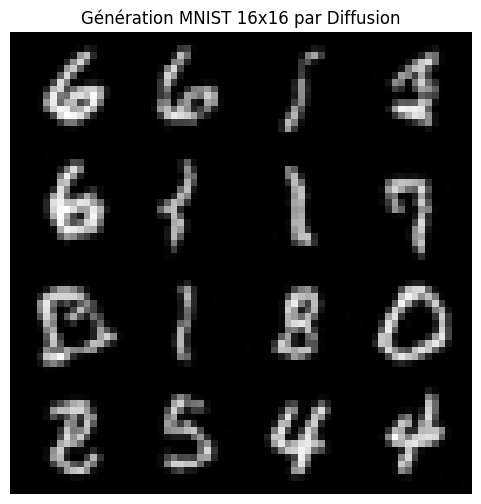

In [41]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid


def generate_digits(n_samples=16):
    device = Config.device
    model = SimpleUNet().to(device)
    model.load_state_dict(torch.load("mnist_diffusion_16x16.pth", map_location=device))
    model.eval()
    
    diffusion = DiffusionSchedule(Config.T, device)
    
    print(f"Génération de {n_samples} images...")

    # 2. Étape 1 : Tirer x_T ~ N(0, I)
    x = torch.randn((n_samples, 1, Config.img_size, Config.img_size)).to(device)
    
    # 3. Étape 2: Boucle inverse de T à 1
    with torch.no_grad():
        for t in reversed(range(Config.T)):
            # On génère z ~ N(0, I) si t > 0, sinon z = 0 (dernière étape pas de bruit) 
            z = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
            
            # Prédiction du bruit à retirer par le réseau (xi_theta)
            # Note: on crée un batch de temps t constant pour toutes les images
            t_tensor = (torch.ones(n_samples) * t).long().to(device)
            predicted_noise = model(x, t_tensor)
            
            # 4. Étape 4: Application de la formule de reconstruction            
            alpha = diffusion.alpha[t]
            alpha_bar = diffusion.alpha_bar[t]
            beta = diffusion.beta[t]
            
            # Calcul des coefficients pour la stabilité numérique
            # Formule: x_{t-1} = 1/sqrt(alpha) * (x_t - beta/sqrt(1-alpha_bar) * noise) + sigma * z
            coef1 = 1 / torch.sqrt(alpha)
            coef2 = beta / torch.sqrt(1 - alpha_bar)
            
            # Le terme beta_t * z correspond à l'écart type du bruit (sigma)
            sigma = torch.sqrt(beta) 
            
            x = coef1 * (x - coef2 * predicted_noise) + sigma * z

    # 5. Post-traitement
    # Les images sortent de l'espace [-1, 1], on les remet en [0, 1] pour l'affichage
    x = (x.clamp(-1, 1) + 1) / 2
    x = x.cpu()
    return x

def show_results(images):
    # Création d'une grille d'images pour affichage
    grid = make_grid(images, nrow=4, padding=1)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray') # permute pour format matplotlib (H, W, C)
    plt.axis('off')
    plt.title("Génération MNIST 16x16 par Diffusion")
    plt.show()

if __name__ == "__main__":
    generated_images = generate_digits(n_samples=16)
    show_results(generated_images)